In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import itertools
from time import sleep
import os
import seaborn as sns
from itertools import chain

In [4]:
print datetime.datetime.now()
validFilePaths = []
for f in os.listdir("data/anomaly_data"):
    filePath = os.path.join("data/anomaly_data", f)
    if os.path.isdir(filePath):
        continue
    if os.stat(filePath).st_size <= 3:
        continue
    validFilePaths.append(filePath)
    
numF = int(1 * len(validFilePaths))
print 'Using this many files {0}'.format(numF)
validFilePaths = np.random.choice(validFilePaths, numF, replace=False)
df_list = (pd.read_csv(f) for f in validFilePaths)
df = pd.concat(df_list, ignore_index=True)
df = df[df['radiant_win'].notnull()]

2017-06-08 21:42:09.306077
Using this many files 4088


In [5]:
df2 = pd.DataFrame(np.loadtxt('data/goodAnomaliesResidual.csv', delimiter = ','), 
                 columns = ["match_id", "residual"])

df = df.merge(df2, left_on='match_id', right_on='match_id')

matchDictionary = {}
heroColumns = [filter(lambda x: z in x, df.columns) for z in ['hero_id']][0]

# for each row, this function will return all the heroes that the match belongs in
# for example, if the match had an AM and Spectre, we should place this match in each of those bags
def heroesForMatch(row):
    pass

In [6]:
df = df[~df['match_id'].duplicated()]

In [7]:
df = df.sort_values(by='residual', ascending=False)

In [8]:
columns = df.columns
numericalFeatures = ['match_id', 'positive_votes', 'negative_votes', 'first_blood_time', 'radiant_win',
                    'duration', 'kills', 'deaths', 'assists', 'apm', 'kpm', 'kda', 'hero_dmg',
                    'gpm', 'hero_heal', 'xpm', 'totalgold', 'totalxp', 'lasthits', 'denies',
                    'tower_kills', 'courier_kills', 'gold_spent', 'observer_uses', 'sentry_uses',
                    'ancient_kills', 'neutral_kills', 'camps_stacked', 'pings', 'rune_pickups', 'abandons',
                    'residual']
numFeatures = [filter(lambda x: z in x, columns) for z in numericalFeatures]
numFeatures = list(chain(*numFeatures))
df = df[numFeatures]

In [9]:
df['match_id'].values.tolist()

[3215302144,
 3215336448,
 3215364864,
 3215253504,
 3215305472,
 3215230208,
 3215313664,
 3215256064,
 3215498240,
 3215429120,
 3215156736,
 3215262464,
 3215291648,
 3215383296,
 3215268352,
 3215188736,
 3215221248,
 3215213312,
 3215156480,
 3215155456,
 3215398656,
 3215357952,
 3215157760,
 3215455232,
 3215124736,
 3215122432,
 3215252736,
 3215201792,
 3215419392,
 3215242496,
 3215248640,
 3215158016,
 3215418880,
 3215237632,
 3215386880,
 3215445760,
 3215202048,
 3215298048,
 3215255552,
 3215439104,
 3215482112,
 3215180288,
 3215126016,
 3215130880,
 3215312640,
 3215146240,
 3215275776,
 3215107840,
 3215369984,
 3215484416,
 3215108096,
 3215418624,
 3215342848,
 3215449600,
 3215411712,
 3215135744,
 3215473408,
 3215191552,
 3215424768,
 3215122176,
 3215236352,
 3215326976,
 3215439872,
 3215176704,
 3215450112,
 3215412480,
 3215304704,
 3215424000,
 3215460608,
 3215357440,
 3215225344,
 3215399168,
 3215165440,
 3215100160,
 3215292928,
 3215406336,
 3215431680,

In [10]:
df['residual'].values.tolist()

[23.783334732055664,
 20.135766983032227,
 19.46851921081543,
 19.223609924316406,
 18.764724731445312,
 18.490245819091797,
 17.277061462402344,
 16.947734832763672,
 16.942398071289062,
 16.77090072631836,
 16.555482864379883,
 16.226909637451172,
 15.990052223205566,
 15.902778625488281,
 15.902181625366211,
 15.423715591430664,
 14.709556579589844,
 14.64592456817627,
 14.618253707885742,
 14.335704803466797,
 14.105602264404297,
 14.096576690673828,
 14.056424140930176,
 13.982555389404297,
 13.970139503479004,
 13.891220092773438,
 13.761789321899414,
 13.733879089355469,
 13.663458824157715,
 13.59416389465332,
 13.353803634643555,
 13.22453784942627,
 13.182890892028809,
 13.149872779846191,
 13.004798889160156,
 12.826828956604004,
 12.745077133178711,
 12.738612174987793,
 12.71006965637207,
 12.571928024291992,
 12.549835205078125,
 12.524263381958008,
 12.452695846557617,
 12.317193984985352,
 12.31189250946045,
 12.143924713134766,
 11.965354919433594,
 11.948304176330566,

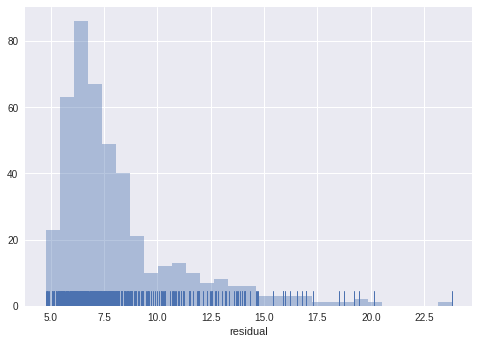

In [11]:
sns.distplot(df['residual'],  kde=False, rug=True)
plt.show()

In [12]:
len(df)

440

In [13]:
plt.close()

In [14]:
residuals = df['residual'].values.tolist()

In [15]:
np.max(residuals) - np.min(residuals)

19.017492294311523

In [16]:
df['residual']

159    23.783335
400    20.135767
224    19.468519
438    19.223610
71     18.764725
413    18.490246
2      17.277061
368    16.947735
311    16.942398
433    16.770901
181    16.555483
352    16.226910
426    15.990052
362    15.902779
105    15.902182
94     15.423716
317    14.709557
434    14.645925
69     14.618254
211    14.335705
209    14.105602
140    14.096577
199    14.056424
161    13.982555
263    13.970140
194    13.891220
249    13.761789
238    13.733879
146    13.663459
139    13.594164
         ...    
30      5.535788
43      5.511476
406     5.465705
162     5.460803
206     5.458718
312     5.451179
377     5.441486
13      5.394897
310     5.386751
216     5.354434
331     5.345767
381     5.336103
431     5.320559
87      5.304674
27      5.253036
212     5.251566
235     5.249150
290     5.163885
172     5.144548
178     5.137314
305     5.134398
66      5.116675
289     5.078004
409     5.074884
132     5.045971
15      4.927567
215     4.892761
201     4.8457

In [48]:
def RadiantDireDifference(row, column):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    radiantSum = 0
    direSum = 0
    for pos in poss:
        radiantSum += row['radiant_'+ pos + '_' + column]
        direSum += row['dire_'+ pos + '_' + column]
    return radiantSum - direSum

def reject_outliers(data, m=1.5):
    return abs(data - np.mean(data)) < m * np.std(data)


def heroKDAdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] + \
                        row[fac + '_' + pos + '_assists'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKDdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def TeamKillDifference(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    radiantSum = 0
    direSum = 0
    for pos in poss:
        radiantSum += row['radiant_'+ pos + '_kills']
        direSum += row["dire" + '_' + pos + '_kills']
    return abs(radiantSum - direSum)

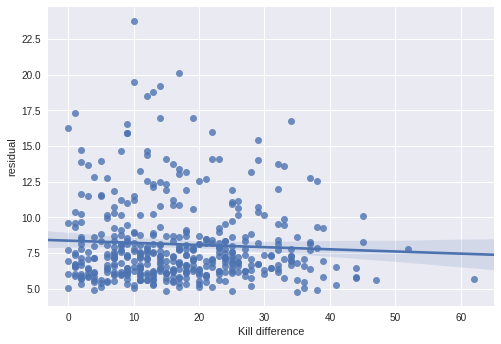

In [18]:
kill_difference = np.abs(df.apply(RadiantDireDifference, args=('kills',), axis=1))
sns.regplot(kill_difference, df['residual'])
ax = plt.gca()
ax.set_xlabel("Kill difference")
plt.show()

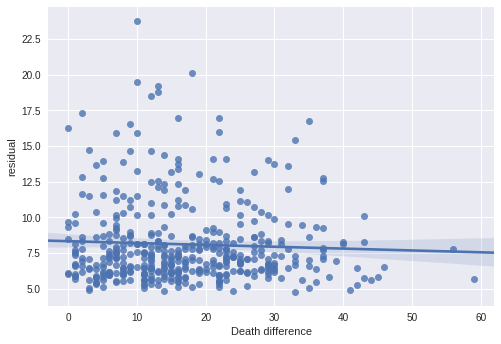

In [19]:
death_difference = df.apply(RadiantDireDifference, args=('deaths',), axis=1)
sns.regplot(np.abs(death_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("Death difference")
plt.show()

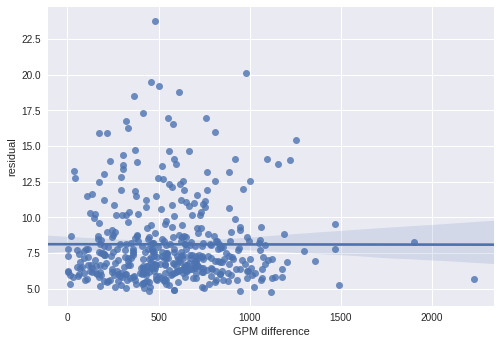

In [43]:
gold_difference = df.apply(RadiantDireDifference, args=('gpm',), axis=1)
above_ = np.abs(gold_difference) <= 5000

indices = np.where(above_)[0]
sns.regplot(np.abs(gold_difference)[above_], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("GPM difference")
plt.show()

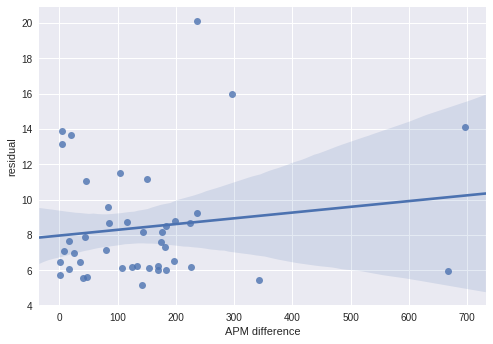

In [21]:
apm_difference = df.apply(RadiantDireDifference, args=('apm',), axis=1)
sns.regplot(np.abs(apm_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("APM difference")
plt.show()

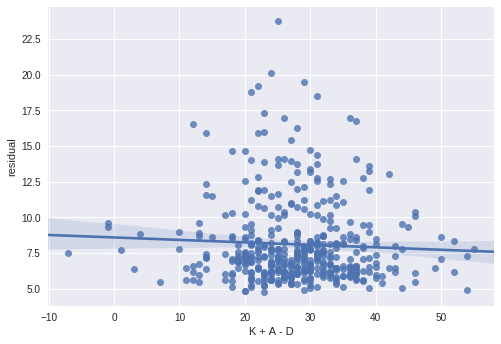

In [22]:
kda = df.apply(heroKDAdeficit, axis=1)
sns.regplot(kda, df['residual'])
ax = plt.gca()
ax.set_xlabel("K + A - D")
plt.show()

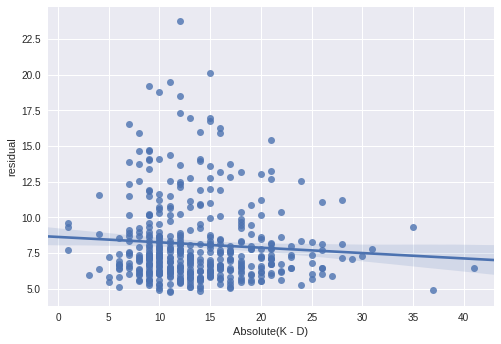

In [23]:
kd = df.apply(heroKDdeficit, axis=1)
sns.regplot(np.abs(kd), df['residual'])
ax = plt.gca()
ax.set_xlabel("Absolute(K - D)")
plt.show()

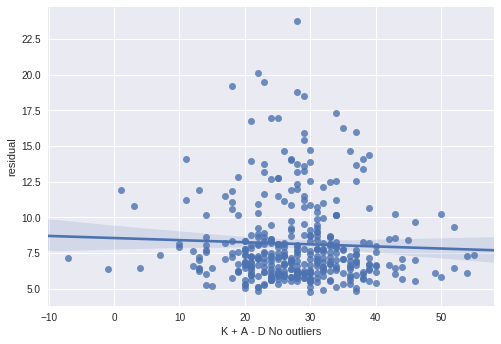

In [24]:
kda = df.apply(heroKDAdeficit, axis=1)
kda_mean = np.mean(kda)
kda_std = np.std(kda)
indices = np.where(np.logical_and(kda <= kda_mean + 1.5*kda_std, kda >= kda_mean-1.5*kda_std))[0]
sns.regplot(kda[indices], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("K + A - D No outliers")
plt.show()

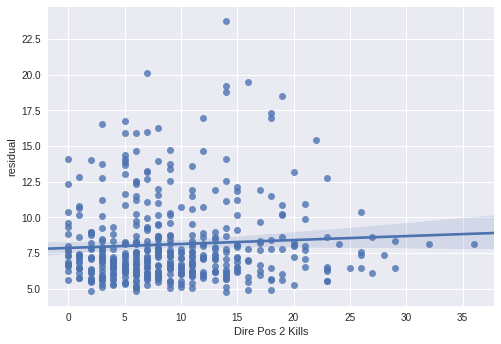

In [32]:
sns.regplot(df['dire_pos2_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Dire Pos 2 Kills")
plt.show()

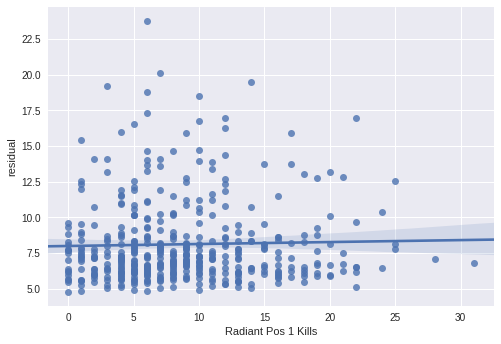

In [33]:
sns.regplot(df['radiant_pos1_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills")
plt.show()

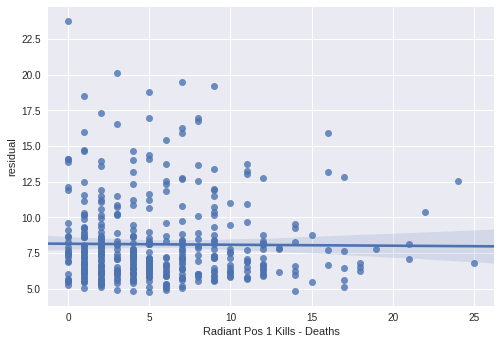

In [45]:
sns.regplot(np.abs(df['radiant_pos1_kills'] - df['radiant_pos1_deaths']), df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills - Deaths")
plt.show()

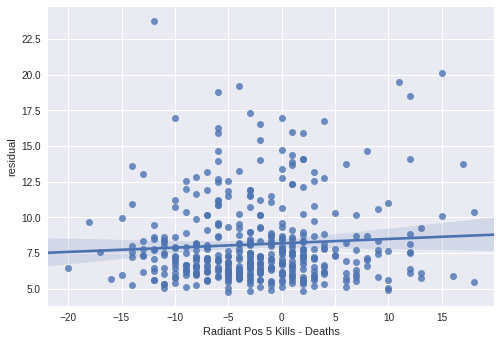

In [47]:
sns.regplot(df['radiant_pos5_kills'] - df['radiant_pos5_deaths'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 5 Kills - Deaths")
plt.show()

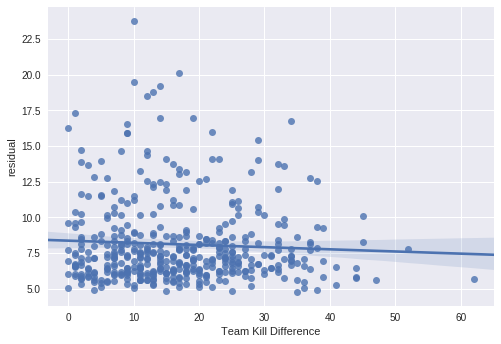

In [50]:
sns.regplot(df.apply(TeamKillDifference, axis=1), df['residual'])
ax = plt.gca()
ax.set_xlabel("Team Kill Difference")
plt.show()

In [27]:
df[df['residual'] > 17]

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
159,3215302144,0,0,133,True,2500,NaN,NaN,8,NaN,...,0,0,0,0,0,0,0,0,0,23.783335
400,3215336448,0,0,118,True,2104,30.0,0.0,4,173.0,...,0,0,0,0,0,0,0,0,0,20.135767
224,3215364864,0,0,516,True,2736,NaN,NaN,1,NaN,...,0,0,0,0,0,0,0,0,0,19.468519
438,3215253504,0,0,259,False,2775,NaN,NaN,2,NaN,...,0,0,0,0,0,0,0,1,0,19.223610
71,3215305472,0,0,152,True,2121,NaN,NaN,3,NaN,...,0,1,0,0,0,0,0,0,0,18.764725
413,3215230208,0,0,119,True,2966,NaN,NaN,7,NaN,...,0,0,0,0,0,0,0,0,0,18.490246
2,3215313664,0,0,231,True,2650,NaN,NaN,4,NaN,...,0,0,0,0,0,0,0,0,0,17.277061


In [28]:
df[df['residual'] < 7.5].sample(10, random_state=1)

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
280,3215095296,0,0,10,True,2576,NaN,NaN,2,NaN,...,0,0,0,0,0,0,0,0,0,6.769508
333,3215159040,0,0,0,False,2147,NaN,NaN,13,NaN,...,0,0,0,0,0,0,0,0,0,4.765842
171,3215438848,0,0,70,True,2940,NaN,NaN,5,NaN,...,0,0,0,0,0,0,0,1,0,5.615639
377,3215137280,0,0,82,True,2392,NaN,NaN,2,NaN,...,0,0,0,0,0,0,0,0,0,5.441486
258,3215271168,0,0,250,True,2365,NaN,NaN,5,NaN,...,0,0,0,1,0,0,0,0,0,6.599493
206,3215099648,0,0,238,True,1981,NaN,NaN,0,NaN,...,0,0,0,0,0,1,0,0,0,5.458718
260,3215121920,0,0,5,True,2015,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,6.901570
167,3215327488,0,0,62,False,2595,NaN,NaN,2,NaN,...,0,0,0,0,0,0,0,0,0,6.248038
27,3215325696,0,0,10,True,2694,NaN,NaN,11,NaN,...,0,0,0,0,0,0,0,0,0,5.253036
241,3215126272,0,0,94,False,2239,NaN,NaN,0,NaN,...,0,0,0,1,0,0,0,0,0,7.415165
